In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/human-age-prediction-synthetic-dataset/Train.csv
/kaggle/input/human-age-prediction-synthetic-dataset/Test.csv


In [3]:
# Get files paths
train_file_path = os.path.join('/kaggle/input/human-age-prediction-synthetic-dataset/', 'Train.csv')
test_file_path = os.path.join('/kaggle/input/human-age-prediction-synthetic-dataset/', 'Test.csv')

# Create file dataframe objects
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

First, we will try to categorize the blood pressure, as it is a complex column to work with, For having many nominal values.

In [4]:
# Function to categorize blood pressure into groups
def categorize_blood_pressure(bp_value):
    systolic, diastolic = map(int, bp_value.split('/'))
    avg_bp = (systolic + diastolic) / 2
    if avg_bp < 90:
        return 'Low'
    elif 90 <= avg_bp <= 120:
        return 'Normal'
    elif 121 <= avg_bp <= 140:
        return 'High'
    else:
        return 'Very High'

# Apply the categorization to the 'Blood Pressure (s/d)' column
train_data['Blood Pressure Category'] = train_data['Blood Pressure (s/d)'].apply(categorize_blood_pressure)

# Drop the original 'Blood Pressure (s/d)' column since we now have the categorical version
train_data = train_data.drop(columns=['Blood Pressure (s/d)'])

Exploring the numerical values data to understand our ranges.

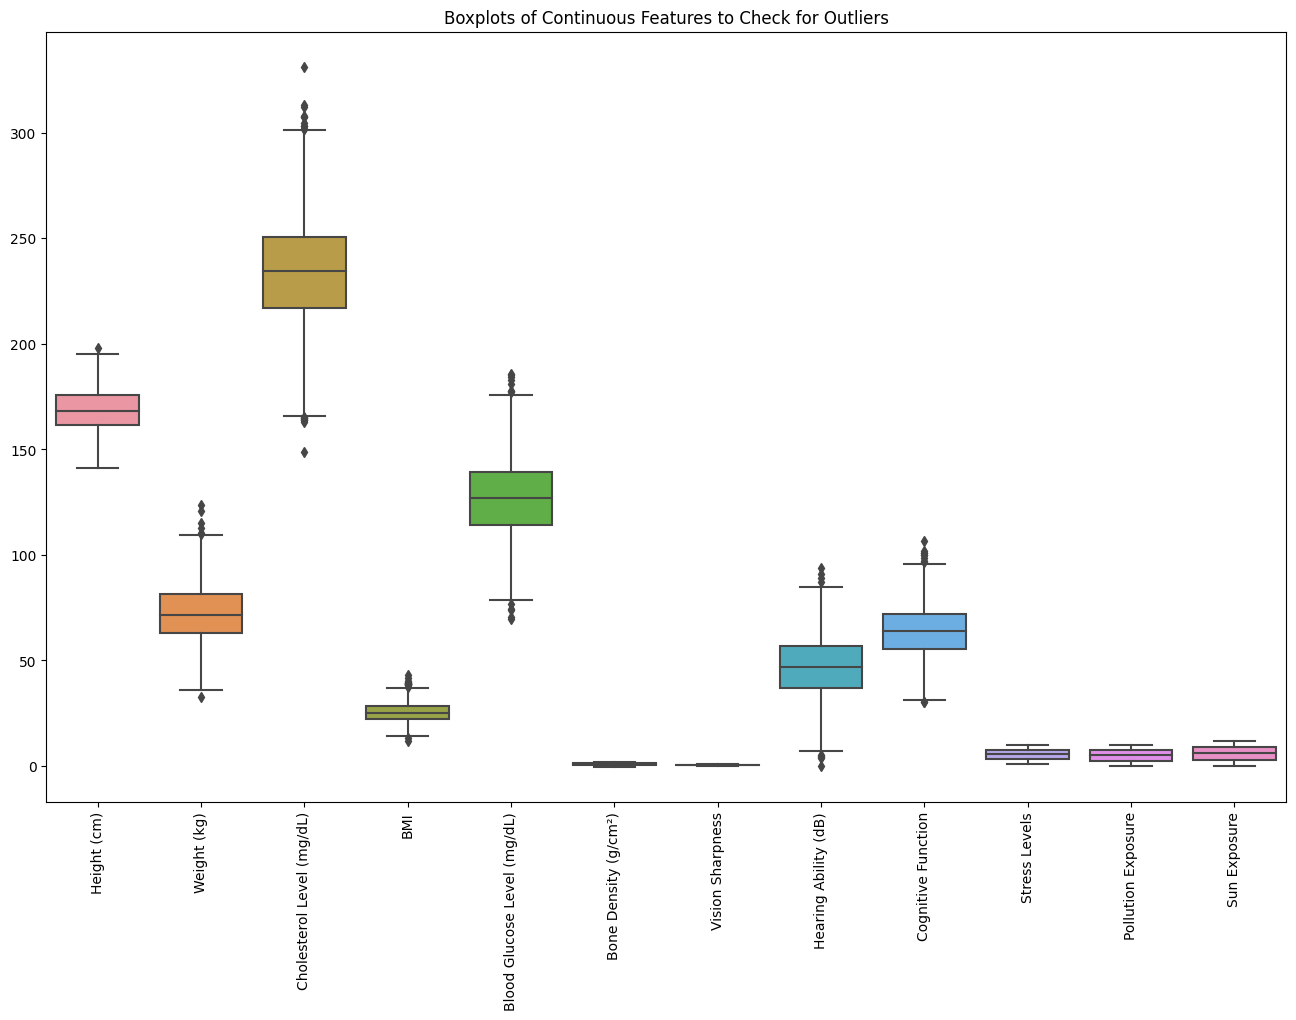

In [5]:
# First, let's check for outliers in the continuous features by plotting boxplots
# We'll select continuous features only for this purpose
continuous_columns = ['Height (cm)', 'Weight (kg)', 'Cholesterol Level (mg/dL)', 
                      'BMI', 'Blood Glucose Level (mg/dL)', 'Bone Density (g/cm²)', 
                      'Vision Sharpness', 'Hearing Ability (dB)', 'Cognitive Function', 
                      'Stress Levels', 'Pollution Exposure', 'Sun Exposure']

# Plotting boxplots to visually inspect for outliers
plt.figure(figsize=(16, 10))
sns.boxplot(data=train_data[continuous_columns])
plt.xticks(rotation=90)
plt.title('Boxplots of Continuous Features to Check for Outliers')
plt.show()

We should understand the categorical values as well, these features are more rigid so we should try to find distinctly distributed features that would indicate effects on age 

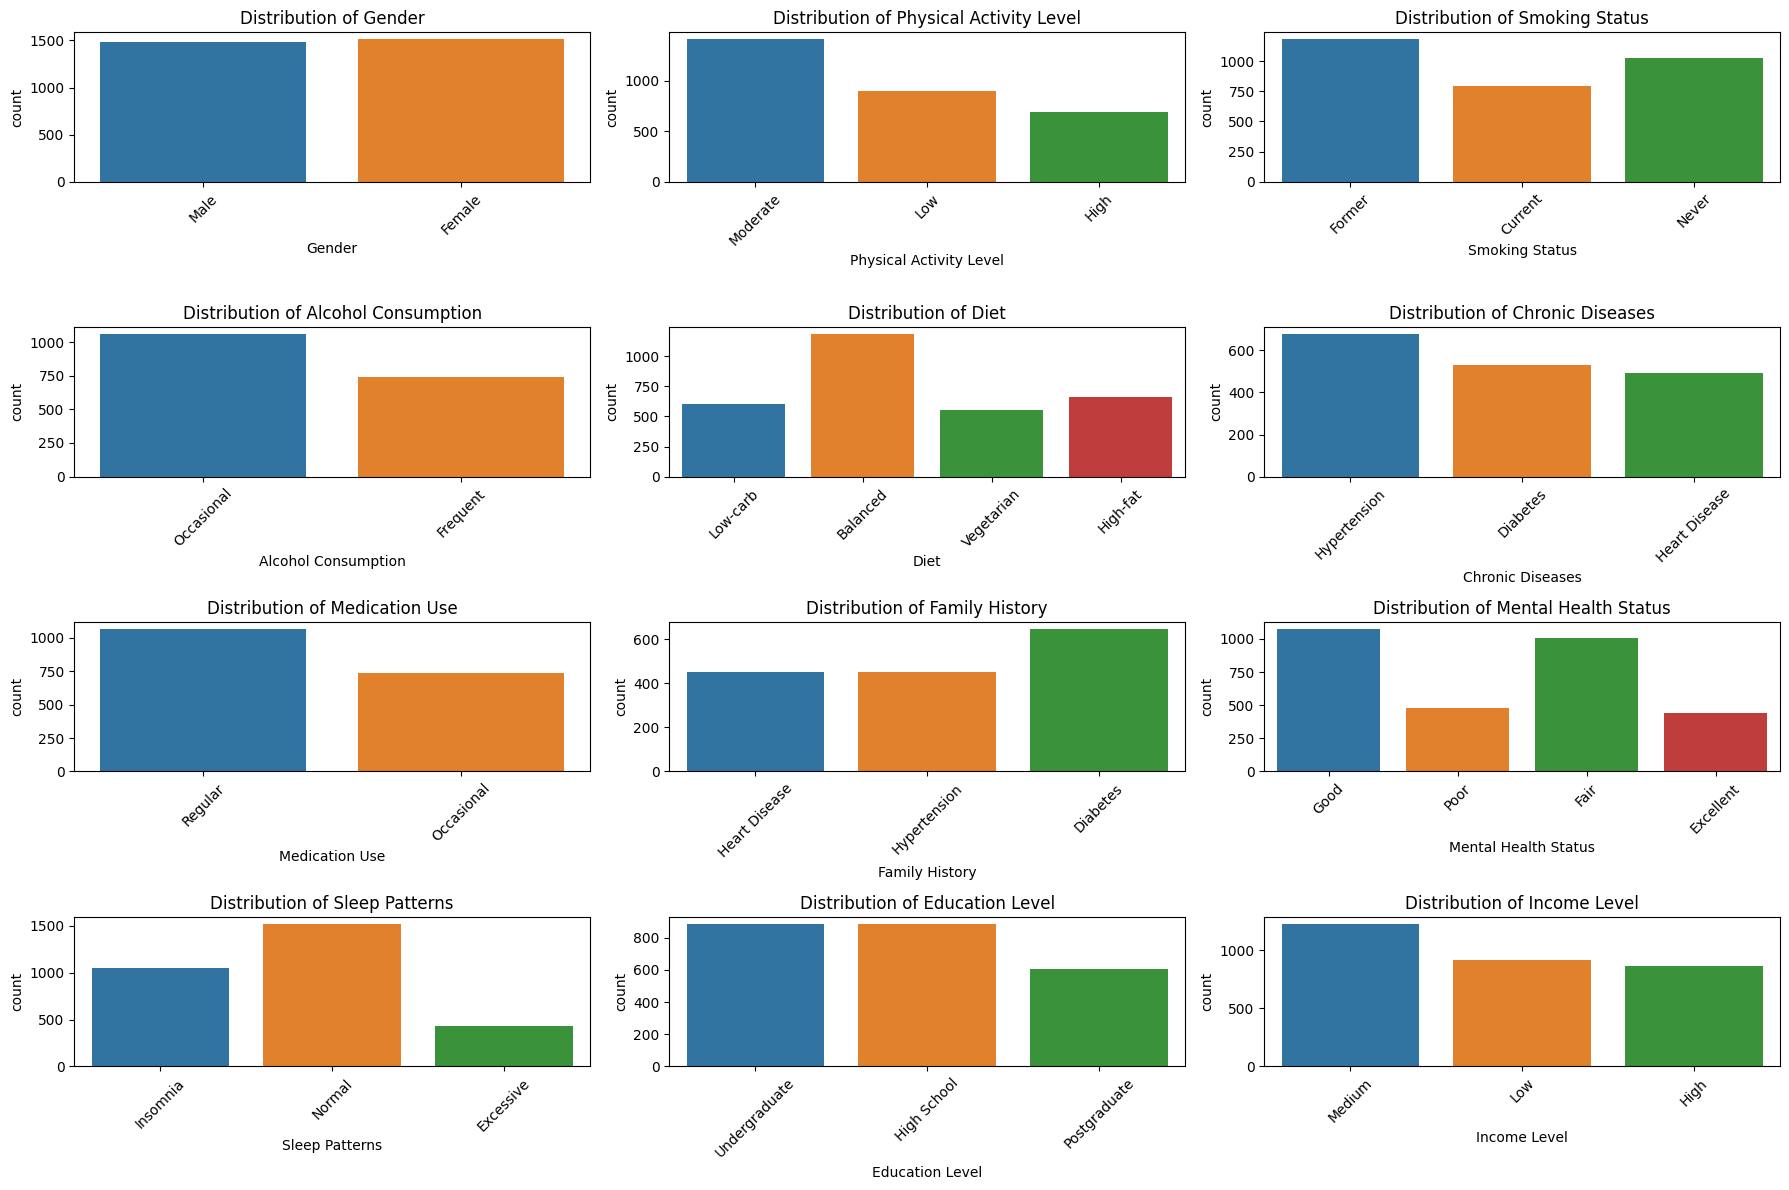

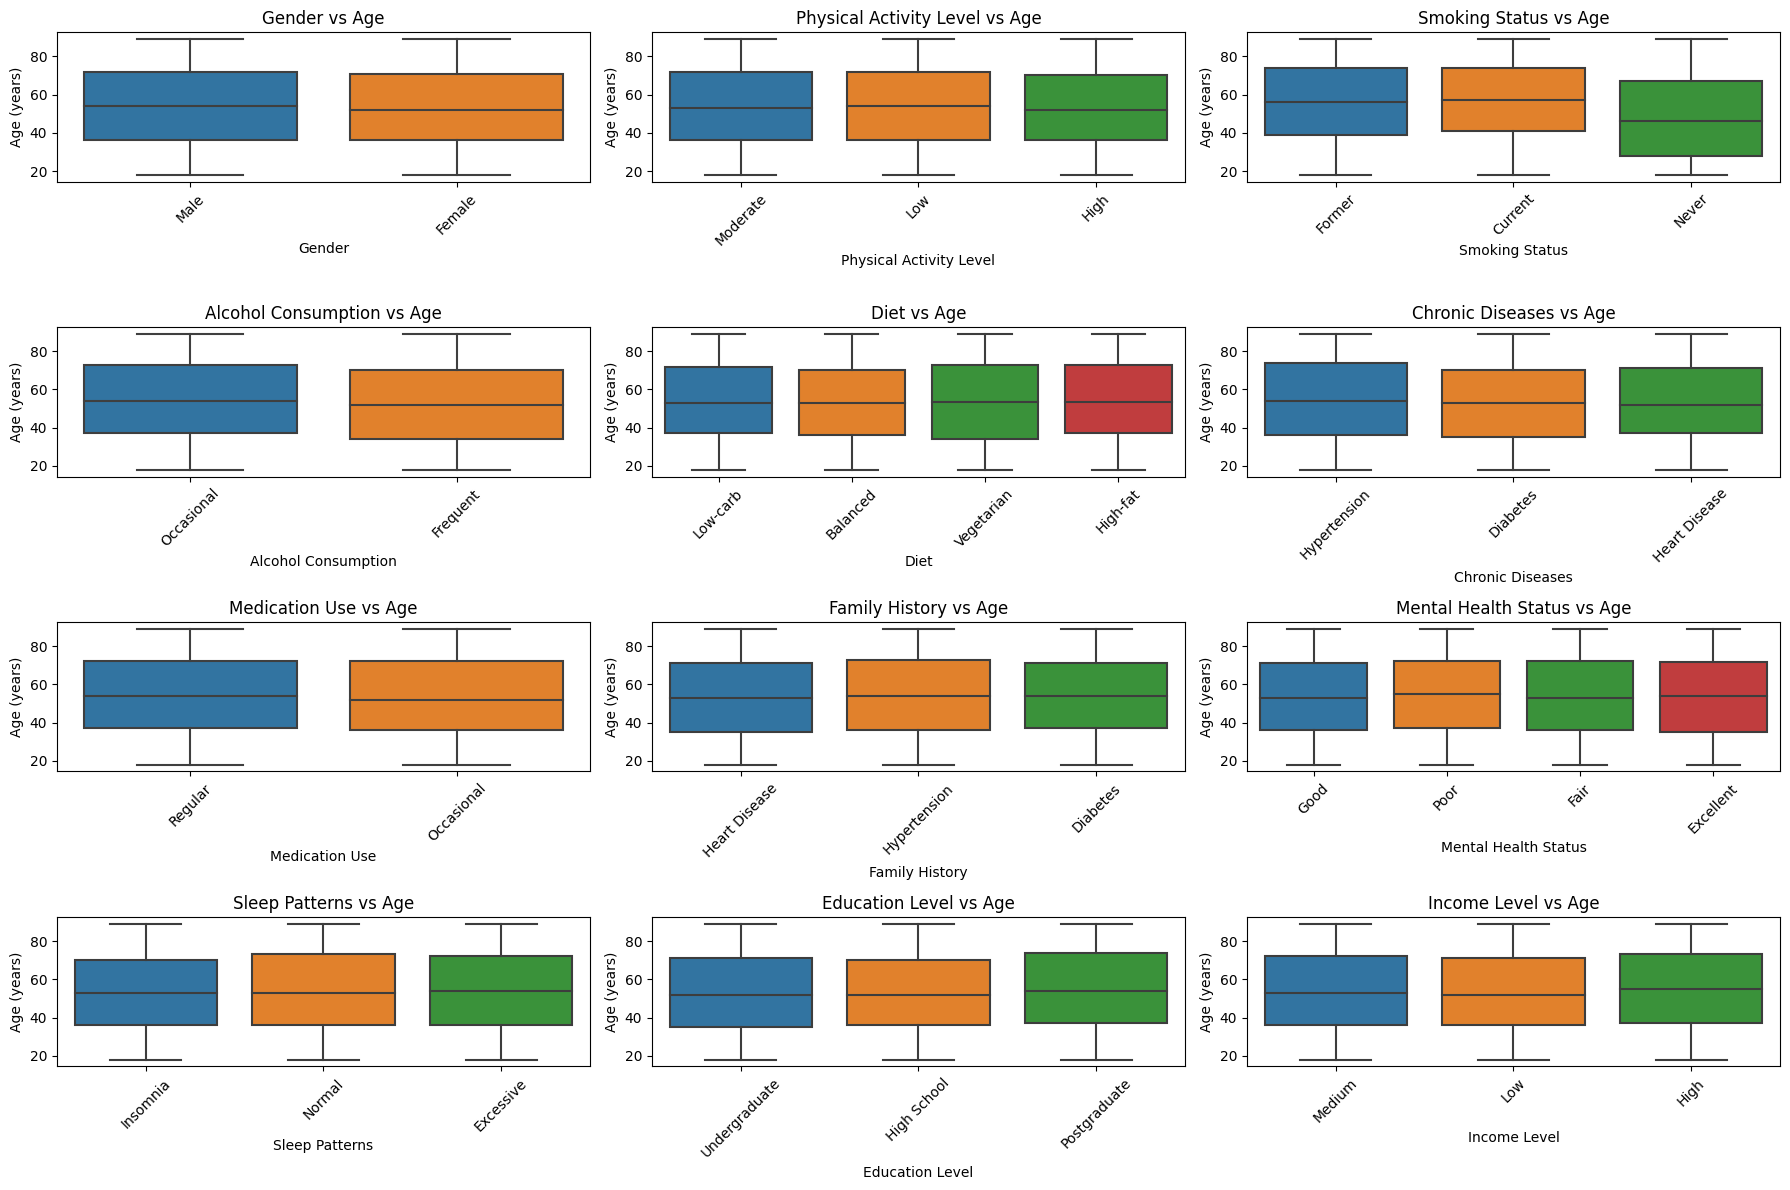

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical features
categorical_columns = ['Gender', 'Physical Activity Level', 'Smoking Status', 'Alcohol Consumption', 
                       'Diet', 'Chronic Diseases', 'Medication Use', 'Family History', 
                       'Mental Health Status', 'Sleep Patterns', 'Education Level', 'Income Level']

# Create subplots for all categorical features
plt.figure(figsize=(18, 12))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(4, 3, i)  # Create a 4x3 grid of plots
    sns.countplot(data=train_data, x=column)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create box plots to see the relationship between categorical features and age
plt.figure(figsize=(18, 12))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=train_data, x=column, y='Age (years)')
    plt.title(f'{column} vs Age')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now, we will seperate the data points by gender and standardize the countinious features, as both gender biological differences and the variable scales for each feature are affecting our end result.

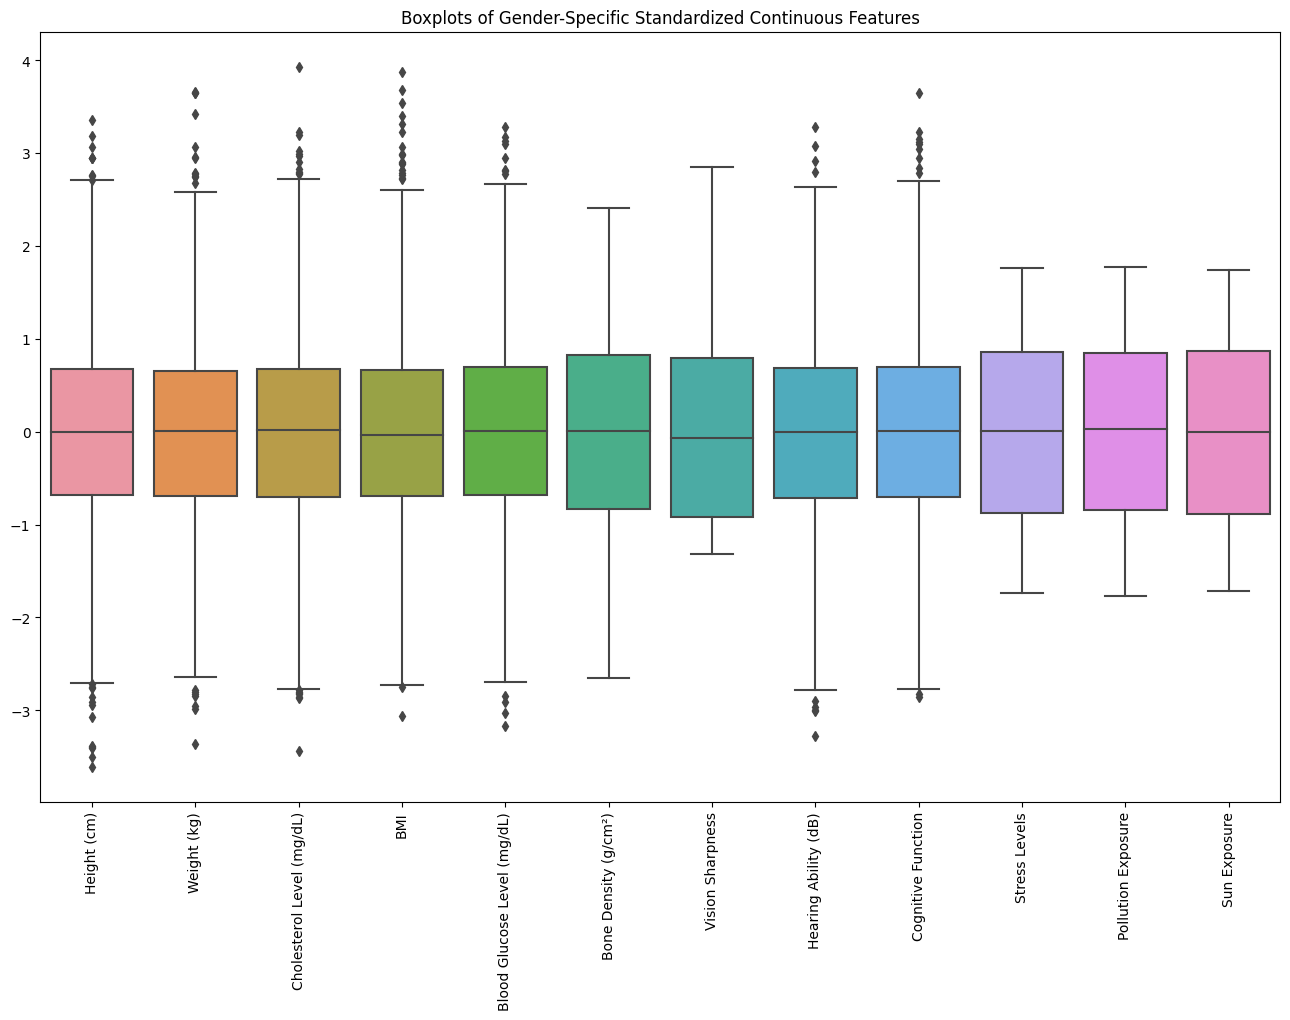

In [7]:
# Separate the dataset by gender
train_data_male = train_data[train_data['Gender'] == 'Male'].copy()
train_data_female = train_data[train_data['Gender'] == 'Female'].copy()

# Standardize the continuous features separately for males and females
scaler = StandardScaler()

# Use .loc[] to explicitly modify specific columns
train_data_male.loc[:, continuous_columns] = scaler.fit_transform(train_data_male[continuous_columns])
train_data_female.loc[:, continuous_columns] = scaler.fit_transform(train_data_female[continuous_columns])

# Combine the datasets back together
train_data_standardized = pd.concat([train_data_male, train_data_female], axis=0)

# Plot the standardized boxplots
plt.figure(figsize=(16, 10))
sns.boxplot(data=train_data_standardized[continuous_columns])
plt.xticks(rotation=90)
plt.title('Boxplots of Gender-Specific Standardized Continuous Features')
plt.show()

we should try to find some correlation between features for further feature engineering.

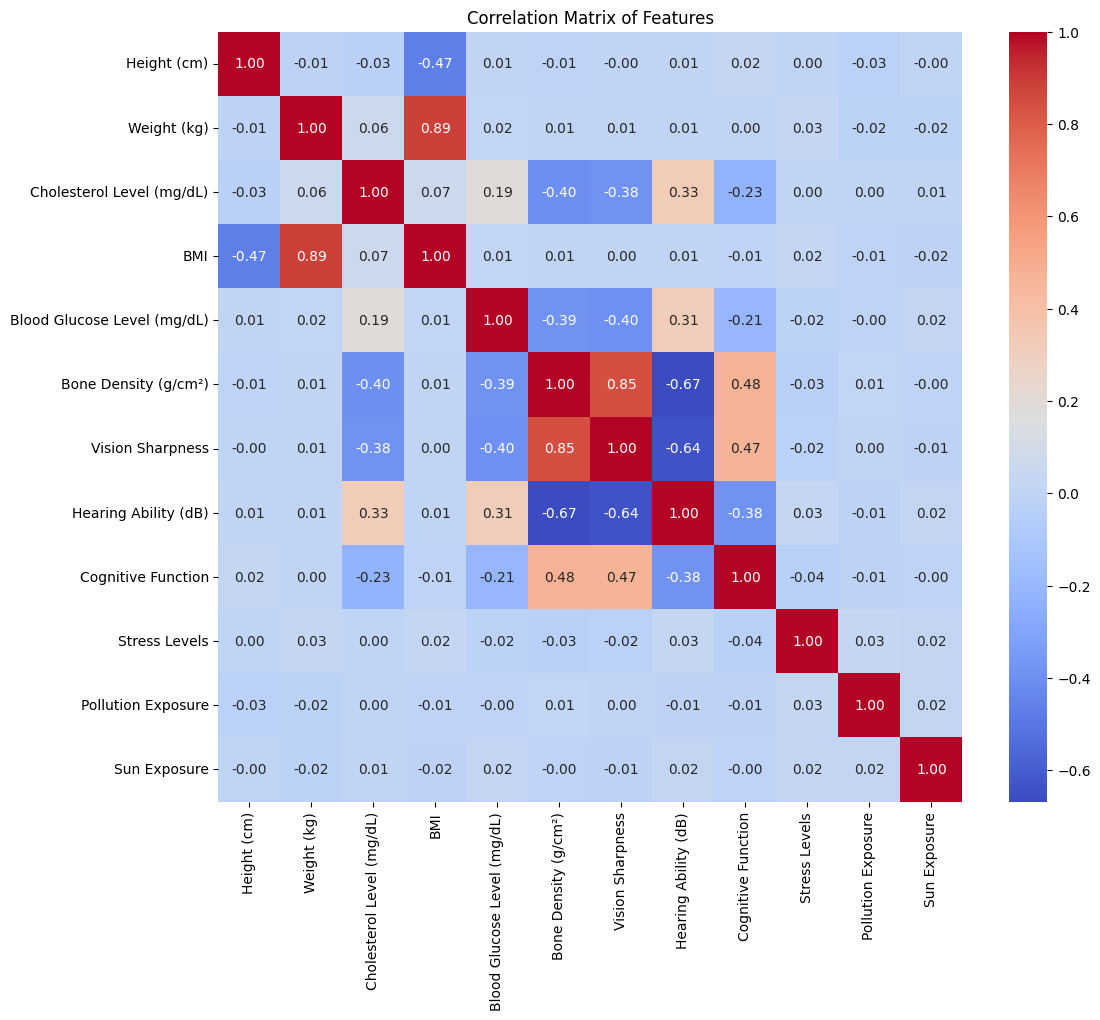

In [8]:
# Calculate the correlation matrix (for continuous features)
corr_matrix = train_data_standardized[continuous_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

As we can see, bone density, hearing ability and vision sharpness, are the most interacting features, as we will soon see.

We will now try to do some basic predictions to set a baseline to refer to in the future using a comparison of some appropriate models to find the best base results.

In [9]:
X = train_data_standardized.drop(columns=['Age (years)'])
y = train_data_standardized['Age (years)']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Function to compare models
def compare_models(X_train, X_test, y_train, y_test):
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'LightGBM': LGBMRegressor(random_state=42),
        'CatBoost': CatBoostRegressor(random_state=42, silent=True),
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'SVR': SVR(),
        'KNN': KNeighborsRegressor(),
        'MLP': MLPRegressor(random_state=42, max_iter=500
                           )
    }
    
    # Dictionary to store results
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = mae
        print(f'{name} MAE: {mae}')
    
    # Find the model with the lowest MAE
    best_model = min(results, key=results.get)
    print(f'Best Model: {best_model} with MAE of {results[best_model]}')
    return models[best_model]

# Compare models
best_model = compare_models(X_train_scaled, X_test_scaled, y_train, y_test)

RandomForest MAE: 4.307483333333333
XGBoost MAE: 4.685548801422119
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3110
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 37
[LightGBM] [Info] Start training from score 53.430833
LightGBM MAE: 4.386348222312505
CatBoost MAE: 4.222957658493879
LinearRegression MAE: 4.3251141342896
Ridge MAE: 4.327192523165036
Lasso MAE: 4.585678499386483
SVR MAE: 5.13324944379002
KNN MAE: 6.304333333333334
MLP MAE: 4.663064022591478
Best Model: CatBoost with MAE of 4.222957658493879


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                              Feature  Importance
5                Bone Density (g/cm²)   42.701400
6                    Vision Sharpness   21.253955
7                Hearing Ability (dB)    5.697292
36     Blood Pressure Category_Normal    3.623429
2           Cholesterol Level (mg/dL)    3.191860
8                  Cognitive Function    2.811546
4         Blood Glucose Level (mg/dL)    2.553906
9                       Stress Levels    2.552765
11                       Sun Exposure    2.131285
3                                 BMI    1.994516
10                 Pollution Exposure    1.851175
1                         Weight (kg)    1.725653
0                         Height (cm)    1.691306
16               Smoking Status_Never    0.618668
12                        Gender_Male    0.586994
30              Sleep Patterns_Normal    0.356012
15              Smoking Status_Former    0.355681
29            Sleep Patterns_Insomnia    0.317369
18                      Diet_High-fat    0.303099


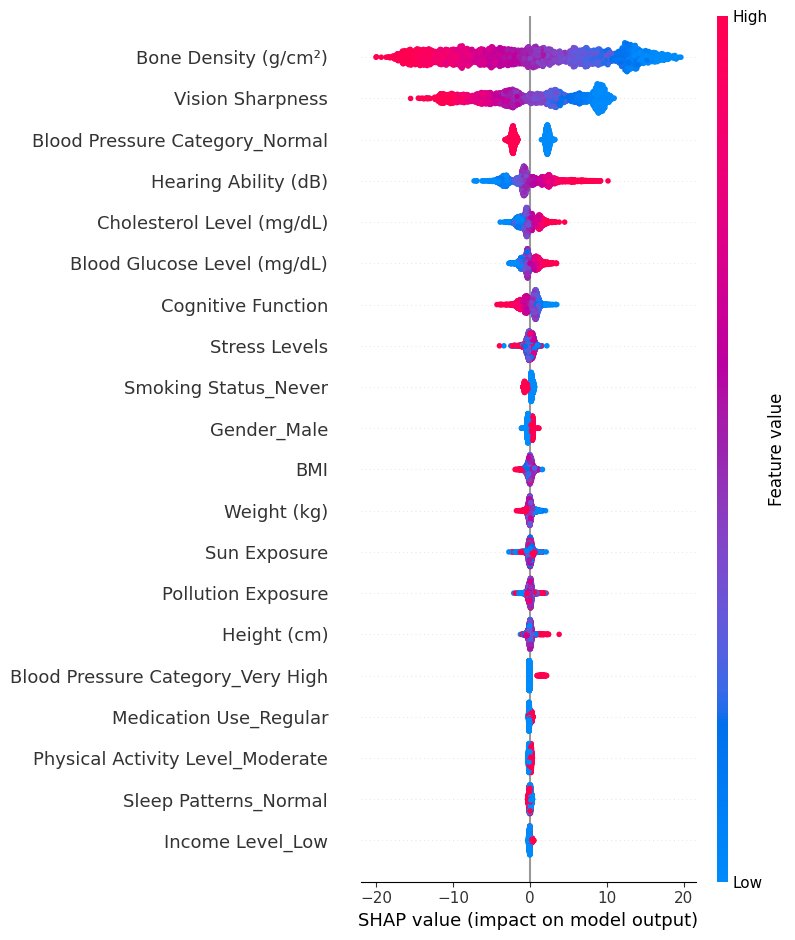

In [10]:
# Get feature importances
importances = best_model.get_feature_importance()
feature_names = X_encoded.columns
# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importances)

import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_encoded)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_encoded, feature_names=X_encoded.columns)

Negative SHAP values indicate Younger AGE, while the more positive(right side) you go, the prediction will lean towards an Older AGE.

The Redder the data point means the value it's visualsing has a higher value, While the Bluer that point is, the lower the value.

Notice! that lower hearing ability means the subject can hear more subtle noises therefore, lower(Blue) is a sign of a healthier body.

In [11]:
# from sklearn.model_selection import RandomizedSearchCV
# from catboost import CatBoostRegressor

# # Define the hyperparameter grid
# param_distributions = {
#     'iterations': [100, 200, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'depth': [4, 6, 8, 10],
#     'l2_leaf_reg': [1, 3, 5, 7],
#     'border_count': [32, 64, 128]
# }

# # Initialize the CatBoost Regressor
# catboost_model = CatBoostRegressor(random_state=42, silent=True)

# # RandomizedSearchCV for hyperparameter tuning
# random_search = RandomizedSearchCV(catboost_model, param_distributions, n_iter=20, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
# random_search.fit(X_train_scaled, y_train)

# # Get the best parameters and MAE
# best_catboost = random_search.best_estimator_
# y_pred = best_catboost.predict(X_test_scaled)
# mae = mean_absolute_error(y_test, y_pred)

# print(f'Best Hyperparameters: {random_search.best_params_}')
# print(f'Improved MAE: {mae}')


The best performance was found with the following parametes:

Best Hyperparameters: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 4, 'border_count': 128}

Improved MAE: 4.115429889012899

the fine tuning improved the results from 4.5 to 4.1 MAE